# Bernoulli Verification Example - Connectivity

A beam with a hinge at the middle around Y is fixed at both ends. It is loaded with a contcentrated force at the middle and constant distributed loads in Z direction. Peak displacement is measured as the mesh is refined.

In [1]:
from sigmaepsilon.solid.fem.cells import B2 as Beam

# units in kN, cm
L, d, t = 100.0, 1.2, 0.4
Ex, nu = 21000.0, 0.25
F = 1.0
q = 1.0


## Linear Solution

In [2]:
from sigmaepsilon.solid import Structure, LineMesh, PointData
from polymesh.space import StandardFrame, PointCloud, frames_of_lines
from polymesh.space.utils import index_of_closest_point
from sigmaepsilon.solid import BeamSection
from linkeddeepdict.tools import getallfromkwargs
from neumann.linalg import linspace
from neumann.array import repeat
from linkeddeepdict import LinkedDeepDict
import numpy as np

# section
section = BeamSection('CHS', d=d, t=t, n=16)
section.calculate_section_properties()
section_props = section.section_properties
A, Ix, Iy, Iz = getallfromkwargs(['A', 'Ix', 'Iy', 'Iz'], **section_props)

# material
G = Ex / (2 * (1 + nu))
Hooke = np.array([
    [Ex*A, 0, 0, 0],
    [0, G*Ix, 0, 0],
    [0, 0, Ex*Iy, 0],
    [0, 0, 0, Ex*Iz]
])

i_first, i_middle, i_last = None, None, None


def build_structure(n: int):
    global i_first, i_middle, i_last
    
    # space
    GlobalFrame = StandardFrame(dim=3)

    # mesh
    p0 = np.array([0., 0., 0.])
    p1 = np.array([L, 0., 0.])
    coords = linspace(p0, p1, n+1)
    coords = PointCloud(coords, frame=GlobalFrame).show()
    topo = np.zeros((n, 2), dtype=int)
    topo[:, 0] = np.arange(n)
    topo[:, 1] = np.arange(n) + 1
    i_first = index_of_closest_point(coords, np.array([0, 0, 0]))
    i_last = index_of_closest_point(coords, np.array([L, 0, 0]))
    i_middle = index_of_closest_point(coords, np.array([L/2, 0, 0]))
    
    # essential boundary conditions
    fixity = np.zeros((coords.shape[0], 6)).astype(bool)
    fixity[i_first, :] = True
    fixity[i_last, :] = True

    # natural boundary conditions
    nLoadCase = 2
    # nodal loads
    nodal_loads = np.zeros((coords.shape[0], 6, nLoadCase))
    nodal_loads[i_middle, 2, 0] = F
    # cell loads
    cell_loads = np.zeros((topo.shape[0], topo.shape[1], 6, nLoadCase))
    cell_loads[:, :, 2, 1] = q
    
    # connectivity
    conn = np.ones((topo.shape[0], topo.shape[1], 6))
    conn[int(n/2 - 1), -1, 4] = 0.
    
    # pointdata
    pd = PointData(coords=coords, fixity=fixity, loads=nodal_loads, 
                   frame=GlobalFrame)

    # celldata
    frames = repeat(GlobalFrame.show(), topo.shape[0])
    areas = np.full(topo.shape[0], section.A)
    cd = Beam(topo=topo, loads=cell_loads, connectivity=conn, frames=frames)

    # set up mesh and structure
    mesh = LineMesh(pd, cd, model=Hooke, frame=GlobalFrame)
    structure = Structure(mesh=mesh)
    return structure


## Verification

In [3]:
structure = build_structure(100)
structure.linsolve()
dofsol = structure.nodal_dof_solution(store='dofsol')


In [4]:
0.5 * F * (L/2)**3 / (3 * Ex * Iy), dofsol[i_middle, 2, 0]

(10.390145314018124, 10.390145316609585)

In [5]:
q * (L/2)**4 / (8 * Ex * Iy), dofsol[i_middle, 2, 1]

(389.63044927567967, 389.68240011635606)

## Convergence Study

In [6]:
ns = [2, 4, 6, 8, 10, 20, 40, 60, 80, 100]
#ns = [2, 4, 10]
uz_conc, uz_dist = [], []
uz_conc_control = 0.5 * F * (L/2)**3 / (3 * Ex * Iy)
uz_dens_control = q * (L/2)**4 / (8 * Ex * Iy)
for n in ns:
    structure = build_structure(n)
    structure.linsolve()
    dofsol = structure.nodal_dof_solution(store='dofsol')
    uz_conc.append(dofsol[i_middle, 2, 0] / uz_conc_control)
    uz_dist.append(dofsol[i_middle, 2, 1] / uz_dens_control)

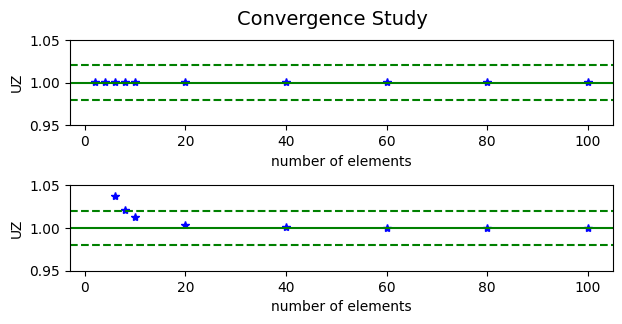

In [7]:
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 3))  # in inches
fig.suptitle('Convergence Study', fontsize=14)

gs = gridspec.GridSpec(2, 1, hspace=0.7)
axes = []

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylabel('UZ')
ax1.plot(ns, uz_conc, 'b*')

ax2 = fig.add_subplot(gs[1, 0])
ax2.set_ylabel('UZ')
ax2.plot(ns, uz_dist, 'b*')

axes.append(ax1)
axes.append(ax2)
for ax in axes:
    ax.axhline(y=1.02, color='g', linestyle='--')
    ax.axhline(y=1, color='g', linestyle='-')
    ax.axhline(y=0.98, color='g', linestyle='--')
    ax.set_ylim([0.95, 1.05])
    ax.set_xlabel('number of elements')
    